# Noise2Void

In the first exercise, we denoised images with CARE using supervised training. As 
discussed during the lecture, ground-truth data is not always available in life 
sciences. But no panic, Noise2Void is here to help!

Indeed Noise2Void (N2V) is a self-supervised algorithm, meaning that it is trained on the data
itself and does not require clean images. The idea is to predict the value of masked
pixels based on the information from the surrounding pixels. 

Two underlying hypothesis allow N2V to work:
1. the signal (i.e., the underlying biological structures) is continuous, meaning that neighboring pixels are somehow correlated and consistent with each other,
2. the noise is, instead, pixel-independent, that is to say the amount of noise in one pixel is independent from the amount of noise in the surrounding pixels.
Fortunately for us, it is very often the case in microscopy images!

*If N2V does not require pairs of noisy and clean images, then how does it train?*

For each training patch, it first selects some random pixels which get *masked*. Masking is 
not simply done by setting pixel values to 0 (which could hinder network performance, as it is an
unexpected, or more properly, *out-of-distribution* value), but by replacing the value with the one of the neighboring pixels.

Then, the network is trained with the objective of predicting the value of the masked pixels. 
Since the masked value is different from the original value, the network is forced to use the information
contained in all the surrounding pixels to infer the masked one. If the noise is pixel-independent, but the signal is not,
then the network will not be able to predict the amount of noise in the original pixel and it will end
up predicting something close to the "clean", or denoised, value, i.e., the signal.

In this notebook, we will use an existing Python library called [Careamics](https://careamics.github.io)
that includes efficient and user-friendly implementations of N2V and other algorithms for image restoration.

<p align="center">
    <img src="https://raw.githubusercontent.com/CAREamics/.github/main/profile/images/banner_careamics.png" width=400>
</p>


## References

- Alexander Krull, Tim-Oliver Buchholz, and Florian Jug. "[Noise2Void - learning denoising from single noisy images.](https://openaccess.thecvf.com/content_CVPR_2019/html/Krull_Noise2Void_-_Learning_Denoising_From_Single_Noisy_Images_CVPR_2019_paper.html)" Proceedings of the IEEE/CVF conference on Computer Vision and Pattern Recognition, 2019.
- Joshua Batson, and Loic Royer. "[Noise2self: Blind denoising by self-supervision.](http://proceedings.mlr.press/v97/batson19a.html)" International Conference on Machine Learning. PMLR, 2019.

<div class="alert alert-block alert-success"><h3>Objectives</h3>
    
- Understand how N2V masks pixels for training
- Learn how to use CAREamics to train N2V
- Think about pixel noise and noise correlation
  
</div>


<div class="alert alert-danger">
Set your python kernel to <code>05_image_restoration</code>
</div>

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import tifffile

from careamics import CAREamist
from careamics.config import (
    create_n2v_configuration,
)
from careamics.transforms import N2VManipulate

%matplotlib inline

/home/TA-FC/conda/envs/05_image_restoration/lib/python3.10/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


<hr style="height:2px;">

## Part 1 Visualize the masking algorithm

In this first part, let's inspect how this pixel masking is done before training a N2V network!

Before feeding patches to the network, a set of transformations, or augmentations, are 
applied to them. For instance in microscopy, we usually apply random 90 degrees rotations
or flip the images. In Noise2Void, we apply one more transformation that replace random pixels
by a value from their surrounding.

In CAREamics, the transformation is called `N2VManipulate`. It has different 
parameters: `roi_size`, `masked_pixel_percentage` and `strategy`.

<div class="alert alert-block alert-info"><h3><b>Task 1: Explore the N2VManipulate parameters</b></h3>

Can you understand what `roi_size`, `masked_pixel_percentage`, and `strategy` do? 
What can go wrong if they are too small or too high?

Try to play with parameters and run the cell below to observe the effects!

*hint: if you get a bit lost, check the documentation of `N2VManipulate` by hovering over it. If you get reaaaaaally lost, you find detailed explanations in the solution notebook.*
</div>

In [19]:
# Define a patch size for this exercise
dummy_patch_size = 64

# Define masking parameters
roi_size = 10 # <-- try changing this
masked_pixel_percentage = 1 # <-- try changing this
strategy = 'uniform' # <-- select between 'uniform' and 'median'

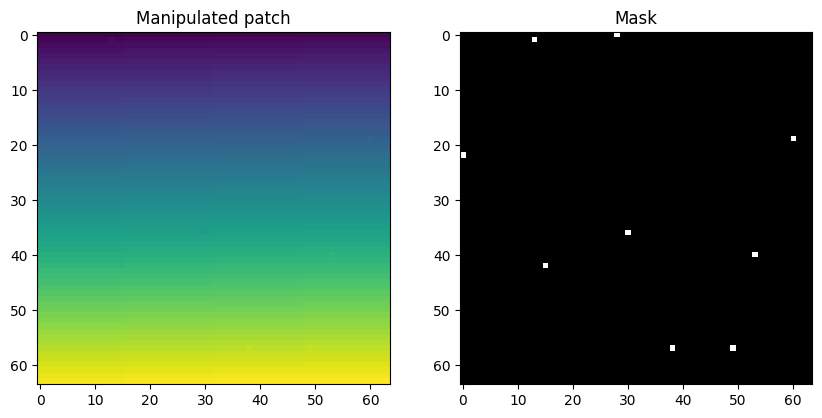

In [21]:
# Create a dummy patch
patch = np.arange(dummy_patch_size**2).reshape(dummy_patch_size, dummy_patch_size)

# The pixel manipulator expects a channel dimension, so we need to add it to the patch
patch = patch[np.newaxis]

# Instantiate the pixel manipulator
manipulator = N2VManipulate(
    roi_size=roi_size,
    masked_pixel_percentage=masked_pixel_percentage,
    strategy=strategy,
)

# And apply it
masked_patch, original_patch, mask = manipulator(patch)

# Visualize the masked patch and the mask
# NOTE: masked pixels are shown as white pixels on the right
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(masked_patch[0])
ax[0].title.set_text("Manipulated patch")
ax[1].imshow(mask[0], cmap="gray")
ax[1].title.set_text("Mask")

<div class="alert alert-block alert-success"><h1><b>Checkpoint 1: N2V masking</b></h1>
</div>

<hr style="height:2px;">

## Part 2: Prepare the data

Now that we understand how the masking works, let's train a Noise2Void network! We will
use a scanning electron microscopy image (SEM).

In [22]:
# Define the paths
root_path = Path("./../data")
root_path = root_path / "denoising-N2V_SEM.unzip/SEM"
assert root_path.exists(), f"Path {root_path} does not exist"

train_images_path = root_path / "train.tif"
validation_images_path = root_path / "validation.tif"

#### Visualize training data

Train image shape: (2500, 1690)


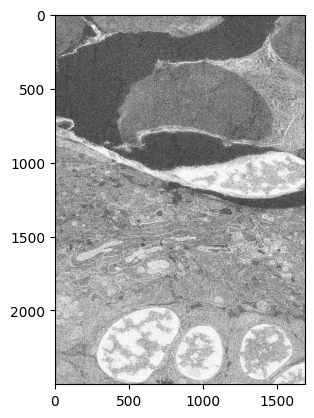

In [23]:
# Load images
train_image = tifffile.imread(train_images_path)
print(f"Train image shape: {train_image.shape}")
plt.imshow(train_image, cmap="gray")

#### Visualize validation data

Validation image shape: (471, 1690)


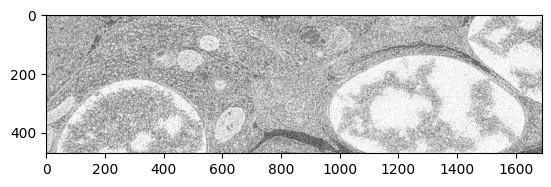

In [24]:
val_image = tifffile.imread(validation_images_path)
print(f"Validation image shape: {val_image.shape}")
plt.imshow(val_image, cmap="gray")

## Part 3: Create a configuration

CAREamics can be configured either from a `.yaml` file, or with an explicitly created config object.
In this note book we will create the config object using helper functions. CAREamics will automatically 
validate all the parameters and will output explicit error if some parameters or a combination of parameters isn't allowed. It will also provide default values for missing parameters.

The helper function limits the parameters to what is relevant for N2V, here is a break down of these parameters:

- `experiment_name`: name used to identify the experiment
- `data_type`: data type, in CAREamics it can only be `tiff` or `array` 
- `axes`: axes of the data, here it would be `YX`. Remember: pytorch and numpy order axes in reverse of what you might be used to. If the data were 3D, the axes would be `ZYX`.
- `patch_size`: size of the patches used for training
- `batch_size`: size of each batch
- `num_epochs`: number of epochs


There are also optional parameters, for more fine grained customization, including:

- `use_augmentations`: whether to use default augmentations (flip and rotation)
- `use_n2v2`: whether to use N2V2, a N2V variant (see optional exercise)
- `n_channels`: the number of channels 
- `roi_size`: size of the N2V manipulation region (remember that parameter?)
- `masked_pixel_percentage`: percentage of pixels to mask
- `logger`: which logger to use
- `checkpoint_params`: Parameters for the checkpoint callback, see PyTorch Lightning documentation
(`ModelCheckpoint`) for the list of available parameters.


Have a look at the [documentation](https://careamics.github.io) to see the full list of parameters and 
their use!


In [ ]:
# Create a configuration using the helper function
training_config = create_n2v_configuration(
    experiment_name="YOUR_NAME_n2v_exp", # <-- change YOUR_NAME
    data_type="tiff",
    axes="YX",
    patch_size=[64, 64],
    batch_size=128,
    num_epochs=10,
    roi_size=11,
    masked_pixel_percentage=0.2,
    logger="tensorboard",
    checkpoint_params={
        "monitor": "val_loss",
        "mode": "min",
        "save_top_k": 1,
    }
)

#### Initialize the Model

Let's instantiate the model with the configuration we just created. CAREamist is the main class of the library, it will handle creation of the data pipeline, the model, training and inference methods.

In [36]:
careamist = CAREamist(source=training_config)

No working directory provided. Using current working directory: /mnt/efs/aimbl_2025/image_restoration/02_Noise2Void.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


## Part 4: Train

Here, we need to specify the paths to training and validation data. We can point to a folder containing 
the data or to a single file. If it fits in memory, then CAREamics will load everything and train on it. If it doesn't, then CAREamics will load the data file by file.

In [37]:
careamist.train(train_source=train_images_path, val_source=validation_images_path)

Extracted 1080 patches from input array.
Computed dataset mean: [39150.88], std: [18692.344]
Extracted 216 patches from input array.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 333 K  | train
---------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.335     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/TA-FC/conda/envs/05_image_restoration/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [46]:
import torch

ckpt = torch.load("checkpoints/YOUR_NAME_n2v_exp-v2.ckpt") # <-- change YOUR_NAME

In [47]:
ckpt["epoch"]

6

<div class="alert alert-block alert-info"><h3><b>Task 2: Tensorboard</b></h3>

Remember the configuration? Didn't we set `logger` to `tensorboard`? Then we can visualize the loss curve!

Open Tensorboard in VS Code (check Task 3 in 01_CARE) to monitor training. 
Logs for this model are stored in the `02_Noise2Void/tb_logs/` folder.
</div>

<div class="alert alert-block alert-success"><h1>Checkpoint 2: Training Noise2Void</h1>
We trained, but how well did it do?
</div>

<hr style="height:2px;">

## Part 5. Prediction

In order to predict on an image, we also need to specify the path. We also typically need
to cut the image into patches, predict on each patch and then stitch the patches back together.

To make the process faster, we can choose bigger tiles than the patches used during training. By default CAREamics uses tiled prediction to handle large images. The tile size can be set via the `tile_size` parameter. Tile overlap is computed automatically based on the network architecture.

In [28]:
preds = careamist.predict(source=train_images_path, tile_size=(256, 256))[0]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/TA-FC/conda/envs/05_image_restoration/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

### Visualize predictions

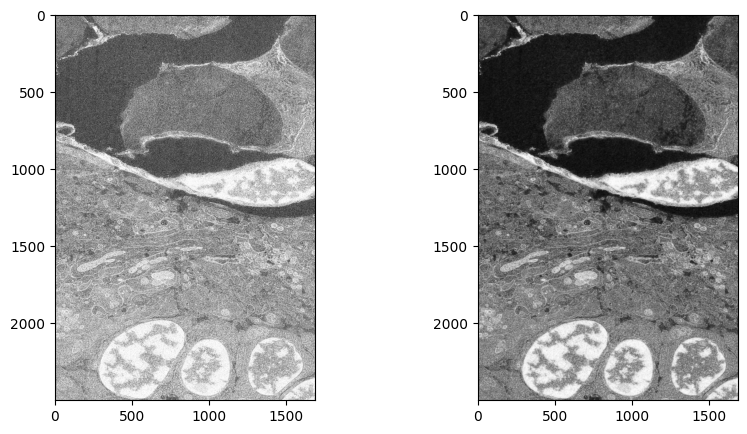

In [29]:
# Show the full image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(train_image, cmap="gray")
ax[1].imshow(preds.squeeze(), cmap="gray")

<div class="alert alert-block alert-warning"><h3><b>Question: Inspect the image closely</b></h3>

If you got a good result, try to inspect the image closely. For instance, the default
window we used for the close-up image:

`y_start` = 200

`y_end` = 450

`x_start` = 600

`x_end` = 850

Do you see anything peculiar in the fine grained details? What could be the reason for that?
</div>

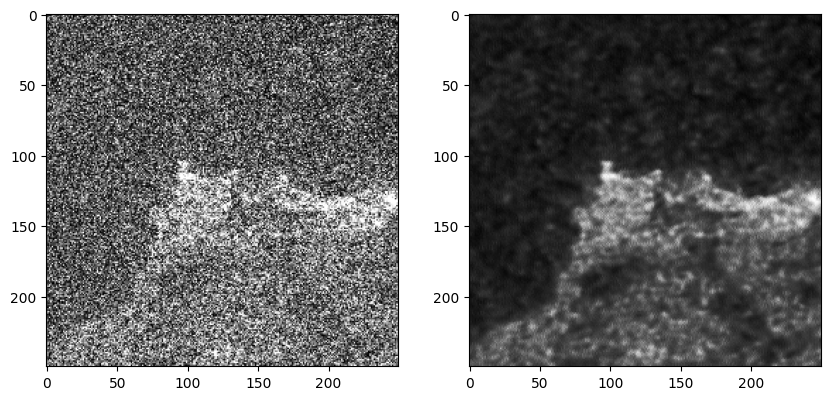

In [30]:
# Show a close up image
y_start = 200
y_end = 450
x_start = 600
x_end = 850

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(train_image[y_start:y_end, x_start:x_end], cmap="gray")
ax[1].imshow(preds.squeeze()[y_start:y_end, x_start:x_end], cmap="gray")

<div class="alert alert-block alert-warning"><h3><b>Question: Check the residuals</b></h3>

Compute the absolute difference between original and denoised image. What do you see? 

</div>

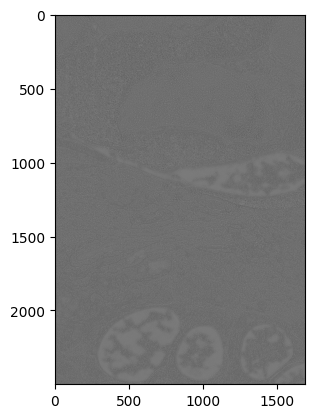

In [31]:
residuals = preds.squeeze() - train_image
plt.imshow(residuals, cmap="gray")

<div class="alert alert-block alert-warning"><h3><b>Answer: Check the residuals</b></h3>

Ideally N2V should remove only the noise, so the residuals should look like pure noise.
However, if the assumptions of N2V are not met (e.g., if the noise is not pixel-independent),
the residuals may contain artifacts or other structures that were not present in the original image.

</div>

<div class="alert alert-block alert-info"><h3><b>Task 4(Optional): Improving the results</b></h3>

CAREamics configuration won't allow you to use parameters which are clearly wrong. However, there are many parameters that can be tuned to improve the results. Go back to the training part and try to play around with the `roi_size` and `masked_pixel_percentage` and see if you can improve the results.

Do the fine-grained structures observed in during the closer look at the image disappear?

</div>

### How we can get results without training?

For instance, we can load the weights (a checkpoint) from the last training we did and use them to predict on a new image.

Here again, CAREamics provides a way to create a CAREamist from a checkpoint only,
allowing predicting without having to retrain.

<div class="alert alert-block alert-info"><h3><b>Task 5: Load Checkpoints</b></h3>

Initialize a new CAREamist from the checkpoint we just created and use it to predict on the same image as before.
You need to specify the path to the checkpoint file `.ckpt`, which is stored in the `checkpoints/` folder inside the experiment folder.

You will find 2 checkpoints: the best one (`experiment_name.ckpt`) and the last one (`last.ckpt`).

</div>

In [ ]:
# Set the path to the checkpoint
checkpoint_path = ... # YOUR CODE HERE

# Check at which epoch the model was saved
from torch import load
ckpt = load(checkpoint_path, map_location="cpu")
print(f"Checkpoint from epoch: {ckpt['epoch']}")

In [ ]:
# Instantiate a CAREamist from a checkpoint
pretrained_careamist = CAREamist(source=checkpoint_path)

# And predict
new_preds = pretrained_careamist.predict(source=train_images_path, tile_size=(256, 256))[0]

# Show the full image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(train_image, cmap="gray")
ax[1].imshow(new_preds.squeeze(), cmap="gray")

<div class="alert alert-block alert-success"><h1>Checkpoint 3: Prediction</h1>
</div>

<hr style="height:2px;"><div class="alert alert-block alert-warning"><h3>Take away questions</h3>

- Why often times the last checkpoint is not the best one?

- Is validation/test useful even if Noise2Void is an unsupervised method?

- We predicted on the same image we trained on, is that a good idea?

- Can you reuse the model on a different dataset with different images?

- Can you train on images with multiple channels? RGB images? Biological channels (GFP, RFP, DAPI)?

- N2V training is unsupervised, how can you be sure that the training worked and is not overfitting or hallucinating?
</div>


<hr style="height:2px;"><div class="alert alert-block alert-success"><h1>End of the exercise</h1>
</div>